#  Setup & Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import joblib
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Set Number Of Classes, Epoch

In [54]:
n_classes = 2
n_epoch = 2

# Load & Preprocess Data

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load preprocessed data
data = joblib.load("data_slen_4_sec.pkl")
x, y_cont, case_ids = data["x"], data["y"], data["c"]

# Clean up NaNs/Infs
x[np.isnan(x)] = np.nanmean(x)
x[np.isinf(x)] = np.nanmean(x)
y_cont = y_cont[~np.isnan(y_cont)]
x = x[~np.isnan(data["y"])]
case_ids = case_ids[~np.isnan(data["y"])]

# Normalize X
x_mean_data = np.mean(x, axis=0)
x_std_data = np.std(x, axis=0)
x = (x - x_mean_data) / x_std_data



# Convert regression BIS to class labels
def bis_to_class(bis):
    
    if n_classes == 4:
        if bis < 40:
            return 0  # Deep Anesthesia
        elif bis < 60:
            return 1  # General Anesthesia
        elif bis < 80:
            return 2  # Light Sedation
        else:
            return 3  # Awake
    elif n_classes == 2:
        if bis < 40:
            return 0  # Deep Anesthesia
        else:
            return 1  # Awake
        
        


y = np.array([bis_to_class(b) for b in y_cont])

# Train-test split based on case ID
unique_cases = np.unique(case_ids)
train_cases, test_cases = train_test_split(unique_cases, test_size=0.2, random_state=42)
train_idx = np.isin(case_ids, train_cases)
test_idx = np.isin(case_ids, test_cases)

x_train, x_test = x[train_idx], x[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Convert to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataloaders
batch_size = 32
train_loader = DataLoader(list(zip(x_train_tensor, y_train_tensor)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(x_test_tensor, y_test_tensor)), batch_size=batch_size, shuffle=False)


Using device: cuda


📊 Training Set Class Distribution:
Class 0: 145985 samples
Class 1: 216775 samples

📊 Test Set Class Distribution:
Class 0: 56739 samples
Class 1: 44494 samples


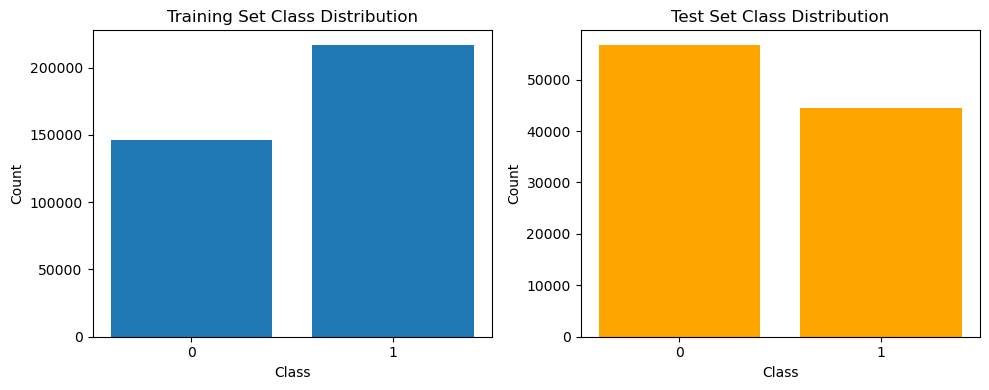

In [57]:
#Convert float labels to int (for classification)
y_train_tensor = y_train_tensor.long()
y_test_tensor = y_test_tensor.long()

# Check Class Distribution
train_labels = y_train_tensor
test_labels = y_test_tensor

classes, train_counts = torch.unique(train_labels, return_counts=True)
classes_test, test_counts = torch.unique(test_labels, return_counts=True)

print("📊 Training Set Class Distribution:")
for cls, count in zip(classes.tolist(), train_counts.tolist()):
    print(f"Class {int(cls)}: {count} samples")

print("\n📊 Test Set Class Distribution:")
for cls, count in zip(classes_test.tolist(), test_counts.tolist()):
    print(f"Class {int(cls)}: {count} samples")



import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Train plot
plt.subplot(1, 2, 1)
plt.bar(classes.cpu(), train_counts.cpu())
plt.title("Training Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(classes.cpu())

# Test plot
plt.subplot(1, 2, 2)
plt.bar(classes_test.cpu(), test_counts.cpu(), color='orange')
plt.title("Test Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(classes_test.cpu())

plt.tight_layout()
plt.show()


# Training Loop for Classification

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from tqdm import tqdm

def train_model(model, train_loader, test_loader, num_epochs=10, use_early_stopping=False):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    if use_early_stopping:
        early_stopper = EarlyStopping(patience=3, min_delta=0.001)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        print(f"\nEpoch {epoch}/{num_epochs}")
        for batch_x, batch_y in tqdm(train_loader, desc="Training", leave=False):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # ─────────────── Evaluation ───────────────
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0

        for batch_x, batch_y in tqdm(test_loader, desc="Evaluating", leave=False):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            with torch.no_grad():
                logits = model(batch_x)
                loss = criterion(logits, batch_y)
                val_loss += loss.item()

                preds = torch.argmax(logits, dim=1)
                correct += (preds == batch_y).sum().item()
                total += batch_y.size(0)

        test_loss = val_loss / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        scheduler.step(test_loss)

        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

        if use_early_stopping and early_stopper(test_loss):
            print(f"⏹️ Early stopping triggered at epoch {epoch}")
            break

    # 📈 Plot Loss and Accuracy Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(test_accuracies, label='Test Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    return model



class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        """
        Args:
            patience (int): Number of epochs to wait before stopping after no improvement.
            min_delta (float): Minimum change in the monitored value to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, current_loss):
        if self.best_loss is None:
            self.best_loss = current_loss
        elif (self.best_loss - current_loss) < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = current_loss
            self.counter = 0




def evaluate_classification_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in loader:
            batch_x = batch_x.to(device)
            logits = model(batch_x)
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


# CNN Model for Classification

In [22]:
class EEG_CNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EEG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.fc1 = nn.Linear(32 * 128, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, 256)
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)  # logits


c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/2


Train Loss: 0.5657 | Train Acc: 0.7052 | Test Loss: 0.5594 | Test Acc: 0.6927

Epoch 2/2


Train Loss: 0.5386 | Train Acc: 0.7303 | Test Loss: 0.5642 | Test Acc: 0.6917


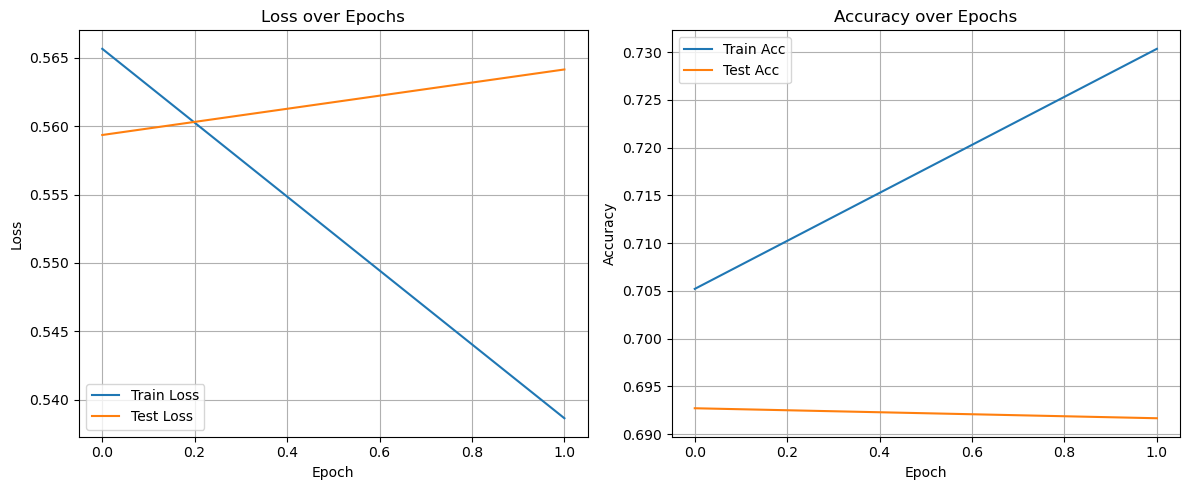

Accuracy: 0.6917
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.61      0.69     56739
           1       0.62      0.79      0.69     44494

    accuracy                           0.69    101233
   macro avg       0.70      0.70      0.69    101233
weighted avg       0.71      0.69      0.69    101233

Confusion Matrix:
 [[34731 22008]
 [ 9206 35288]]


In [ ]:
model = EEG_CNN(num_classes=n_classes)
trained_model = train_model(model, train_loader, test_loader, num_epochs=n_epoch, use_early_stopping=True)
evaluate_classification_model(trained_model, test_loader)

# LSTM Model

In [30]:
class EEG_LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, num_classes=4):
        super(EEG_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            dropout=0.3, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Ensure input shape: (batch_size, seq_len, 1)
        if x.ndim == 2:
            x = x.unsqueeze(-1)  # (batch, 512) → (batch, 512, 1)
        elif x.ndim == 3 and x.shape[-1] != 1:
            x = x.permute(0, 2, 1)  # if (batch, 1, 512) → (batch, 512, 1)

        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)



Epoch 1/2


Train Loss: 0.6631 | Train Acc: 0.6005 | Test Loss: 0.7028 | Test Acc: 0.4395

Epoch 2/2


Train Loss: 0.6593 | Train Acc: 0.6045 | Test Loss: 0.7175 | Test Acc: 0.4395


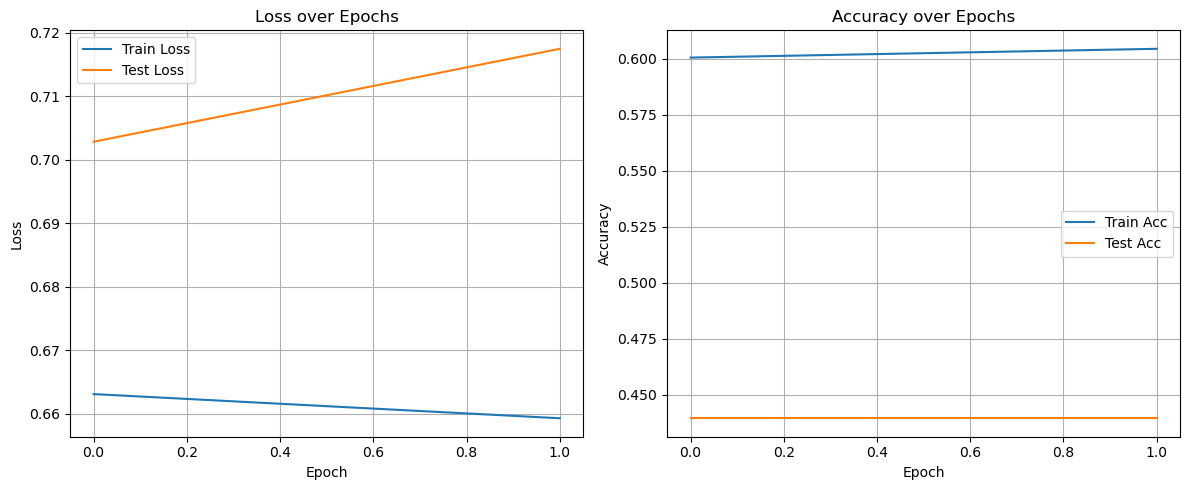

Accuracy: 0.4395
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     56739
           1       0.44      1.00      0.61     44494

    accuracy                           0.44    101233
   macro avg       0.22      0.50      0.31    101233
weighted avg       0.19      0.44      0.27    101233

Confusion Matrix:
 [[    0 56739]
 [    0 44494]]


c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [31]:
# 2. EEG_LSTM
model = EEG_LSTM(num_classes=n_classes)
trained_model = train_model(model, train_loader, test_loader, num_epochs=n_epoch, use_early_stopping=True)
evaluate_classification_model(trained_model, test_loader)

# Attention-based LSTM

In [43]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_classes=4):
        super(AttentionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Input x shape: [batch_size, 512]
        if x.ndim == 2:
            x = x.unsqueeze(-1)  # → [batch, 512, 1]
        elif x.shape[1] == 1:
            x = x.permute(0, 2, 1)  # → [batch, 512, 1]
        
        output, _ = self.lstm(x)  # → [batch, 512, hidden_dim]
        attn_weights = torch.softmax(self.attn(output), dim=1)  # [batch, 512, 1]
        context = torch.sum(attn_weights * output, dim=1)       # [batch, hidden_dim]
        return self.fc(context)  # [batch, num_classes]



Epoch 1/2


Training:   0%|          | 0/11337 [00:00<?, ?it/s]

Train Loss: 0.6385 | Train Acc: 0.6390 | Test Loss: 0.7111 | Test Acc: 0.5260

Epoch 2/2


Train Loss: 0.6143 | Train Acc: 0.6651 | Test Loss: 0.6640 | Test Acc: 0.6020


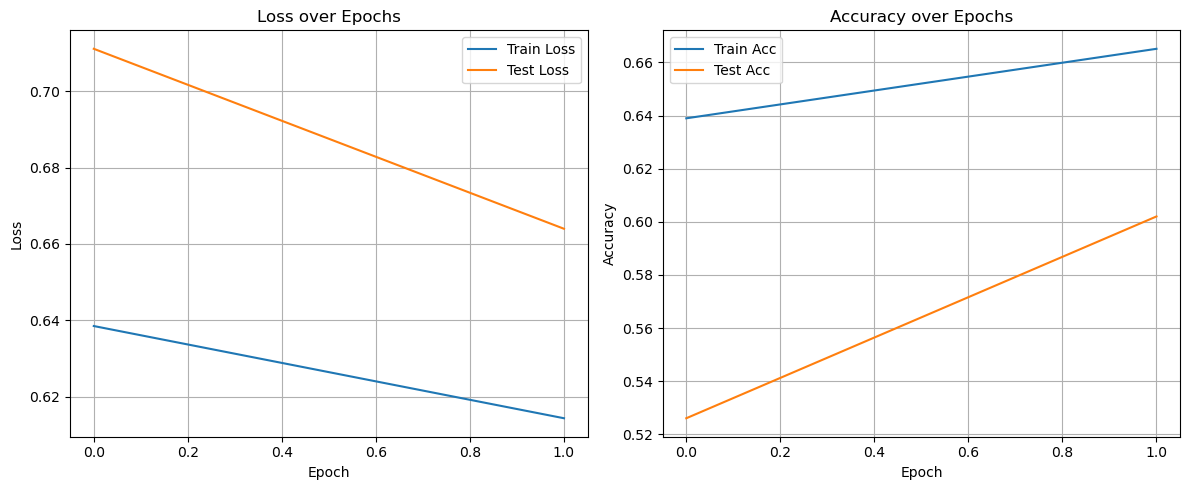

Accuracy: 0.6020
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.53      0.60     56739
           1       0.54      0.70      0.61     44494

    accuracy                           0.60    101233
   macro avg       0.61      0.61      0.60    101233
weighted avg       0.62      0.60      0.60    101233

Confusion Matrix:
 [[29976 26763]
 [13527 30967]]


In [44]:
model = AttentionLSTM(input_dim=1, hidden_dim=64, num_classes=n_classes)
trained_model = train_model(model, train_loader, test_loader, num_epochs=n_epoch, use_early_stopping=True)
evaluate_classification_model(trained_model, test_loader)


# CNN-LSTM Model

In [46]:

class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch, 1, 256)
        x = self.cnn(x)  # (batch, 64, L)
        x = x.permute(0, 2, 1)  # (batch, L, 64) for LSTM
        _, (h_n, _) = self.lstm(x)
        x = h_n[-1]  # Use last hidden state
        x = self.fc(x)
        return x

c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/2


Train Loss: 0.5695 | Train Acc: 0.7004 | Test Loss: 0.5793 | Test Acc: 0.6905

Epoch 2/2


Train Loss: 0.5356 | Train Acc: 0.7287 | Test Loss: 0.5799 | Test Acc: 0.6891


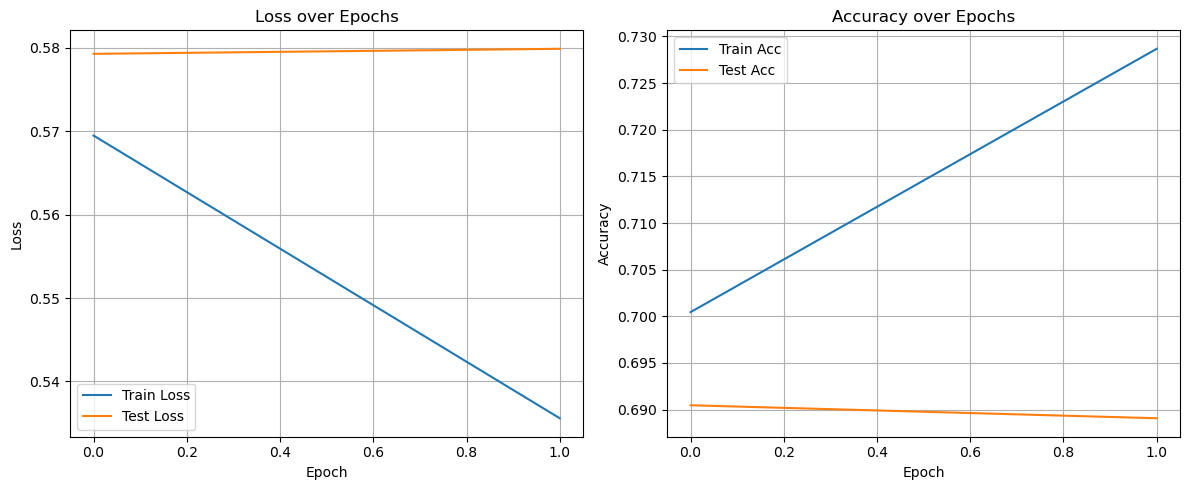

Accuracy: 0.6891
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70     56739
           1       0.62      0.73      0.67     44494

    accuracy                           0.69    101233
   macro avg       0.69      0.69      0.69    101233
weighted avg       0.70      0.69      0.69    101233

Confusion Matrix:
 [[37160 19579]
 [11898 32596]]


In [47]:

model = CNN_LSTM(num_classes=n_classes)
trained_model = train_model(model, train_loader, test_loader, num_epochs=n_epoch, use_early_stopping=True)
evaluate_classification_model(trained_model, test_loader)


# CNN_BiLSTM_Attention

In [48]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)  # BiLSTM -> hidden*2

    def forward(self, lstm_out):
        attn_scores = self.attention(lstm_out)  # [B, T, 1]
        attn_weights = torch.softmax(attn_scores, dim=1)  # softmax over sequence
        context = torch.sum(attn_weights * lstm_out, dim=1)  # [B, hidden_dim*2]
        return context, attn_weights


class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_length=512, num_classes=4):
        super(CNN_BiLSTM_Attention, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # [B, 16, 256]

            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  # [B, 32, 128]
        )

        self.bilstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=1,
                              bidirectional=True, batch_first=True)
        self.attention = AttentionLayer(hidden_dim=64)

        self.classifier = nn.Sequential(
            nn.Linear(64 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        if x.ndim == 2:
            x = x.unsqueeze(1)  # [B, 512] -> [B, 1, 512]

        x = self.cnn(x)  # [B, 1, 512] -> [B, 32, 128]
        x = x.permute(0, 2, 1)  # [B, 32, 128] -> [B, 128, 32]

        lstm_out, _ = self.bilstm(x)  # [B, 128, 128]
        context, attn_weights = self.attention(lstm_out)  # [B, 128]
        out = self.classifier(context)  # [B, num_classes]
        return out


c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/2


Training:   0%|          | 0/11337 [00:00<?, ?it/s]

Train Loss: 0.5639 | Train Acc: 0.7023 | Test Loss: 0.5826 | Test Acc: 0.6907

Epoch 2/2


Train Loss: 0.5344 | Train Acc: 0.7286 | Test Loss: 0.5685 | Test Acc: 0.6997


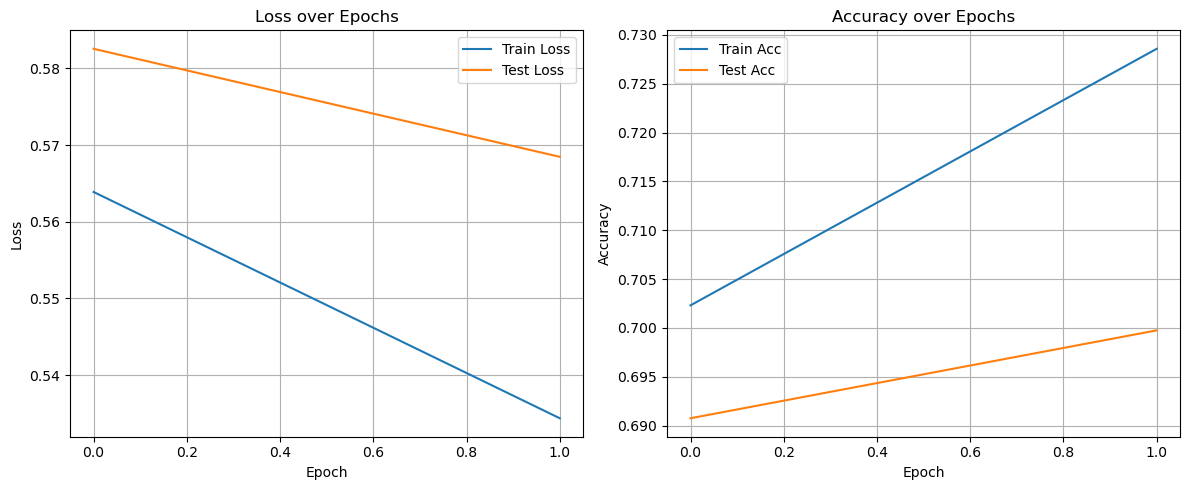

Accuracy: 0.6997
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.74      0.73     56739
           1       0.66      0.65      0.66     44494

    accuracy                           0.70    101233
   macro avg       0.70      0.69      0.69    101233
weighted avg       0.70      0.70      0.70    101233

Confusion Matrix:
 [[41742 14997]
 [15399 29095]]


In [49]:

model = CNN_BiLSTM_Attention(num_classes=n_classes)
trained_model = train_model(model, train_loader, test_loader, num_epochs=n_epoch, use_early_stopping=True)
evaluate_classification_model(trained_model, test_loader)


# GRU Model

In [50]:

class EEG_GRU(nn.Module):
    def __init__(self, num_classes):
        super(EEG_GRU, self).__init__()
        self.gru = nn.GRU(input_size=1, hidden_size=128, batch_first=True, num_layers=2, dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch, 256, 1)
        _, h_n = self.gru(x)
        x = h_n[-1]  # Last layer hidden state
        x = self.fc(x)
        return x



Epoch 1/2


Training:   0%|          | 0/11337 [00:00<?, ?it/s]

Train Loss: 0.6364 | Train Acc: 0.6282 | Test Loss: 0.6214 | Test Acc: 0.6711

Epoch 2/2


Train Loss: 0.5583 | Train Acc: 0.7075 | Test Loss: 0.5953 | Test Acc: 0.6883


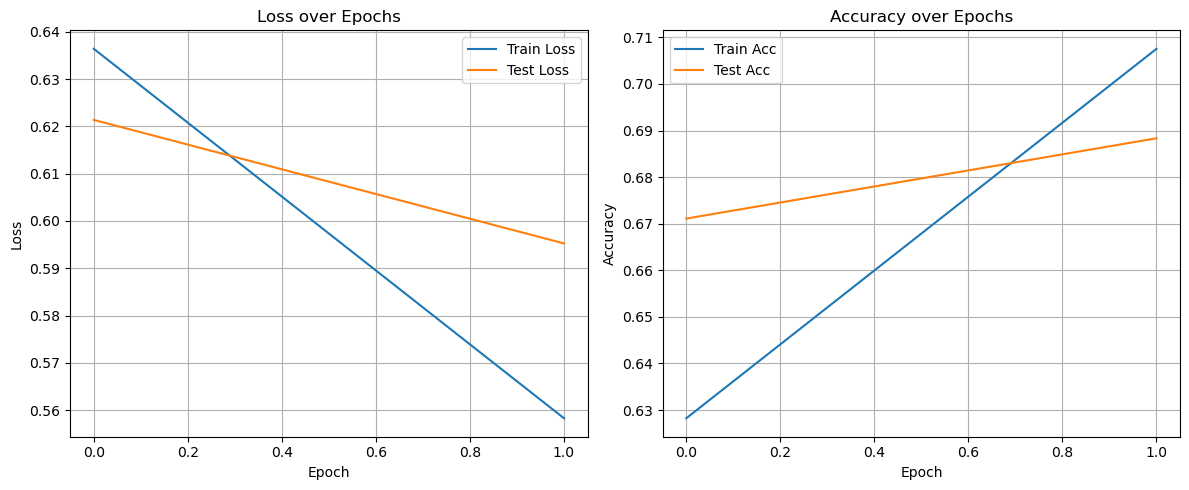

Accuracy: 0.6883
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71     56739
           1       0.63      0.71      0.67     44494

    accuracy                           0.69    101233
   macro avg       0.69      0.69      0.69    101233
weighted avg       0.69      0.69      0.69    101233

Confusion Matrix:
 [[38242 18497]
 [13053 31441]]


In [52]:

# 6. EEG_GRU
model = EEG_GRU(num_classes=n_classes)
trained_model = train_model(model, train_loader, test_loader, num_epochs=n_epoch, use_early_stopping=True)
evaluate_classification_model(trained_model, test_loader)

# EEG Transformer

In [61]:
class EEG_Transformer(nn.Module):
    def __init__(self, seq_len=512, input_dim=1, model_dim=64, num_heads=4, num_layers=2, hidden_dim=128, num_classes=4):
        super(EEG_Transformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)  # Project input to d_model
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers)
        self.fc = nn.Sequential(
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [batch, 512] → [batch, 512, 1]
        if x.ndim == 2:
            x = x.unsqueeze(-1)
        elif x.shape[1] == 1:
            x = x.permute(0, 2, 1)

        x = self.input_proj(x)      # → [batch, 512, model_dim]
        x = self.transformer(x)     # → [batch, 512, model_dim]
        x = x.mean(dim=1)           # Global average pooling
        return self.fc(x)           # → [batch, num_classes]


c:\Users\RAZER\anaconda3\envs\torch_on\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/2


Train Loss: 0.6750 | Train Acc: 0.5975 | Test Loss: 0.7376 | Test Acc: 0.4395

Epoch 2/2


Train Loss: 0.6549 | Train Acc: 0.6201 | Test Loss: 0.6837 | Test Acc: 0.5713


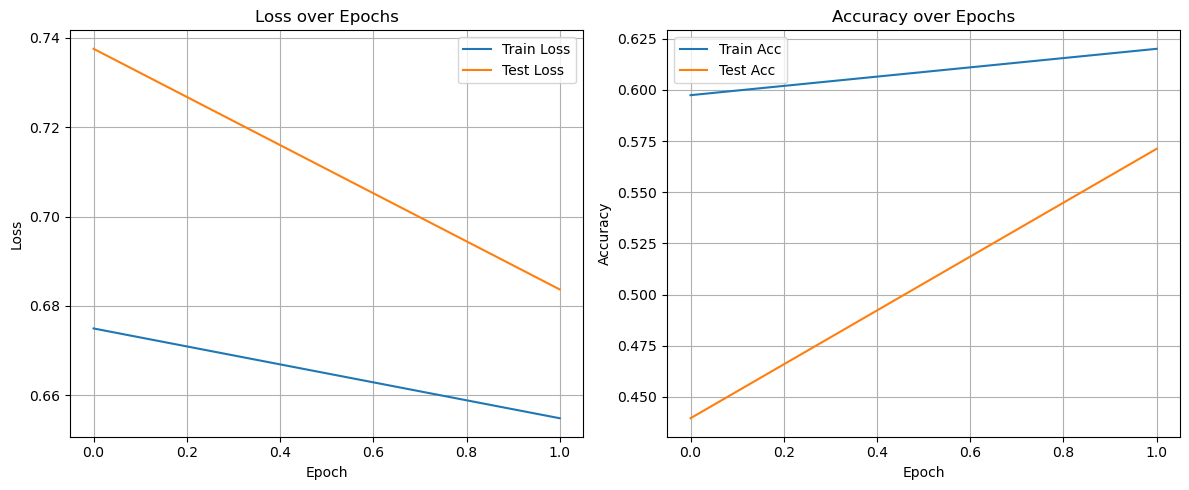

Accuracy: 0.5713
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.58      0.60     56739
           1       0.51      0.56      0.54     44494

    accuracy                           0.57    101233
   macro avg       0.57      0.57      0.57    101233
weighted avg       0.58      0.57      0.57    101233

Confusion Matrix:
 [[32769 23970]
 [19433 25061]]


In [62]:

model = EEG_Transformer(input_dim=1, num_heads=4, num_layers=2, hidden_dim=128, num_classes=n_classes)
trained_model = train_model(model, train_loader, test_loader, num_epochs=n_epoch, use_early_stopping=True)
evaluate_classification_model(trained_model, test_loader)


# Signal-to-Signal Transformer

In [65]:
class SignalToSignalTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=64, num_heads=4, num_layers=2, hidden_dim=128, num_classes=4):
        super(SignalToSignalTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)  # Project input to d_model
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers)
        self.fc = nn.Sequential(
            nn.Linear(model_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: [batch, 512] → [batch, 512, 1]
        if x.ndim == 2:
            x = x.unsqueeze(-1)
        elif x.shape[1] == 1:
            x = x.permute(0, 2, 1)

        x = self.input_proj(x)         # → [batch, 512, model_dim]
        x = self.transformer(x)        # → [batch, 512, model_dim]
        x = x.mean(dim=1)              # Global average pooling
        return self.fc(x)              # → [batch, num_classes]



Epoch 1/2


Training:   0%|          | 0/11337 [00:00<?, ?it/s]

Train Loss: 0.6701 | Train Acc: 0.6020 | Test Loss: 0.7192 | Test Acc: 0.5048

Epoch 2/2


Train Loss: 0.6515 | Train Acc: 0.6240 | Test Loss: 0.6856 | Test Acc: 0.5612


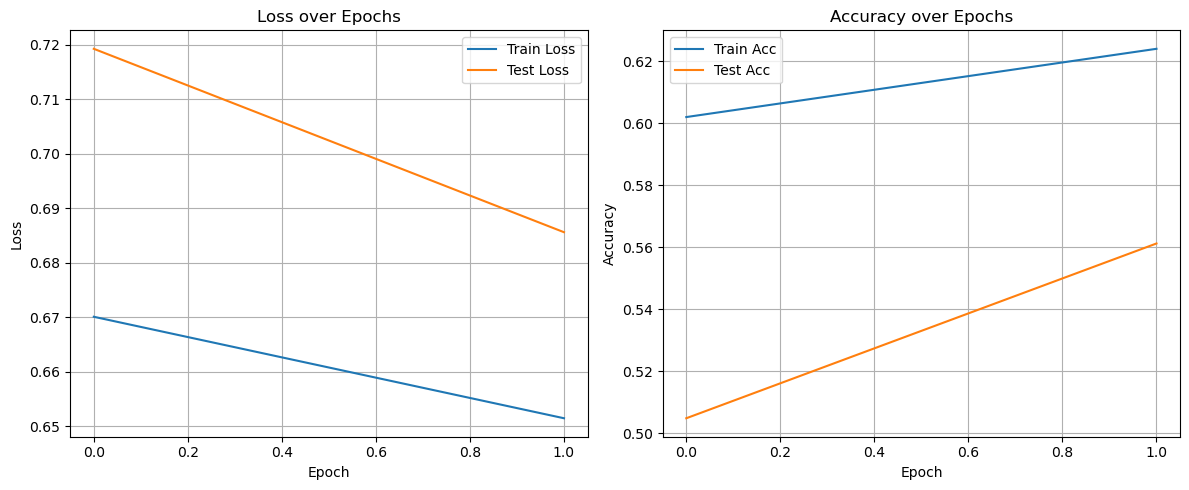

Accuracy: 0.5612
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.55      0.58     56739
           1       0.50      0.58      0.54     44494

    accuracy                           0.56    101233
   macro avg       0.56      0.56      0.56    101233
weighted avg       0.57      0.56      0.56    101233

Confusion Matrix:
 [[31076 25663]
 [18757 25737]]


In [66]:
model = SignalToSignalTransformer(
    input_dim=1,       # since each timestep has 1 value
    model_dim=64,
    num_heads=4,
    num_layers=2,
    hidden_dim=128,
    num_classes=n_classes
)

trained_model = train_model(model, train_loader, test_loader, num_epochs=n_epoch, use_early_stopping=True)
evaluate_classification_model(trained_model, test_loader)


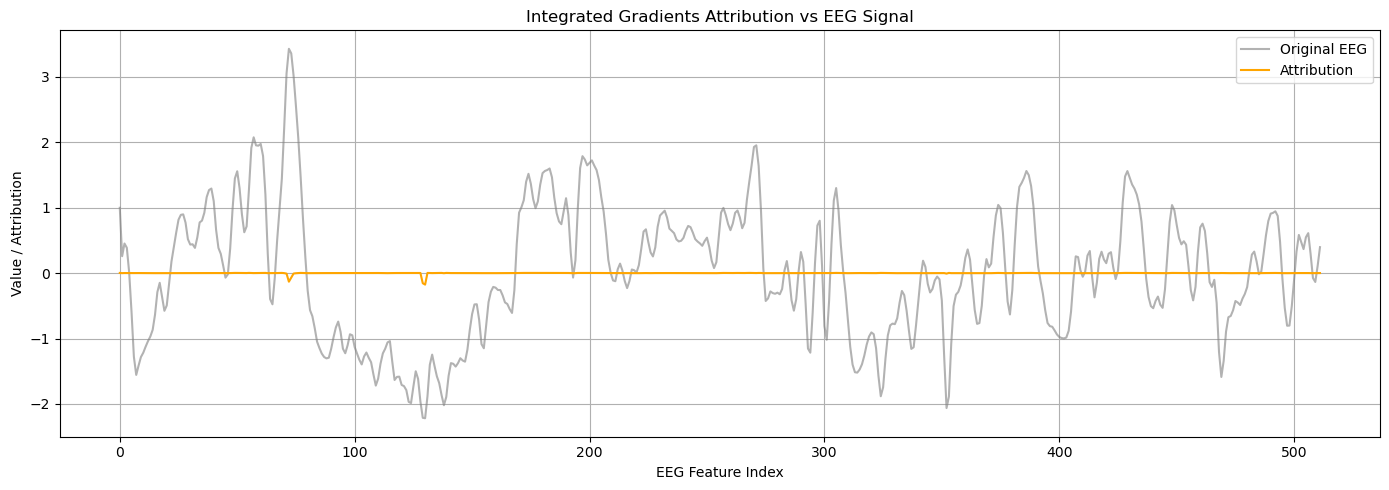

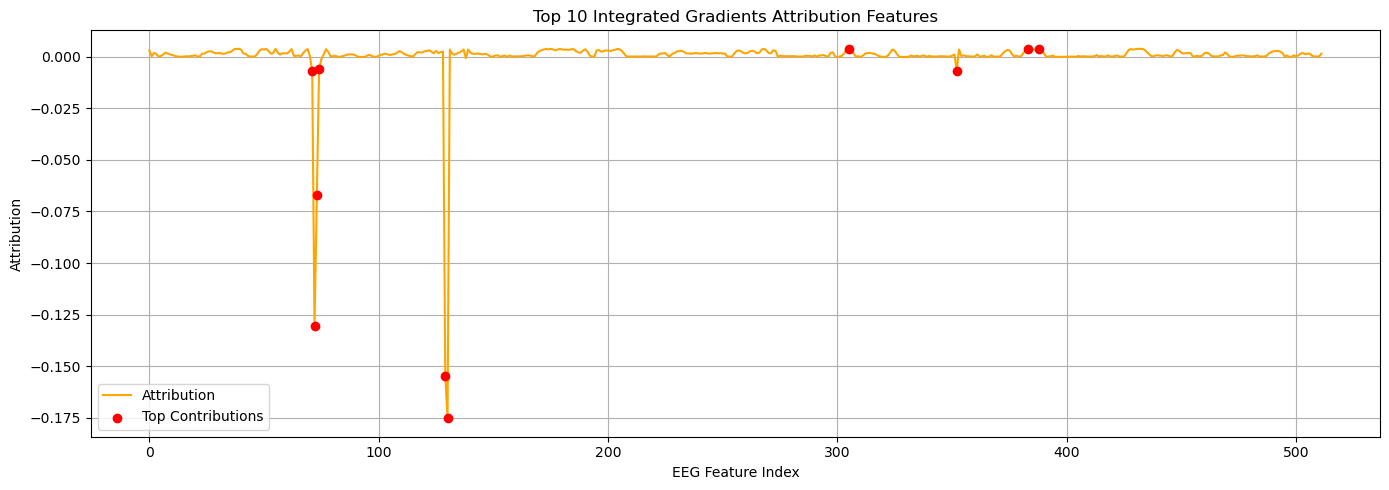

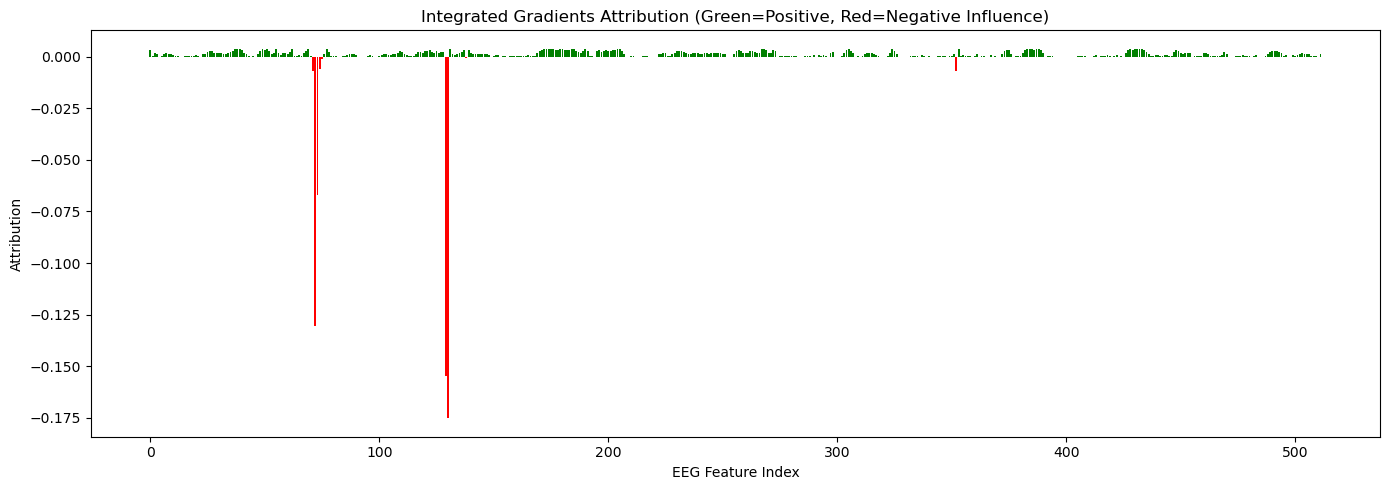

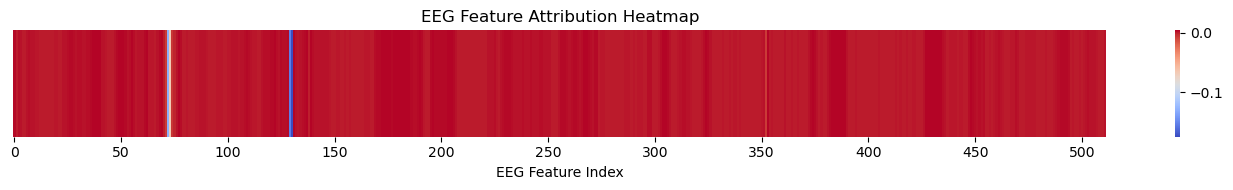

In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from captum.attr import IntegratedGradients

# 1. Wrapped model for softmax output
class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        out = self.model(x)
        return F.softmax(out, dim=1)

# 2. Select one input sample to explain
X_explain = x_test_tensor[0:1].to(device)  # (1, 256)
if X_explain.ndim == 2:
    X_explain = X_explain.unsqueeze(1)  # (1, 1, 256) for CNN models

# 3. Get predicted class
trained_model.eval()
with torch.no_grad():
    logits = trained_model(X_explain)
    predicted_class = torch.argmax(logits, dim=1).item()

# 4. Define baseline
baseline = torch.zeros_like(X_explain).to(device)

# 5. Compute Integrated Gradients
wrapped_model = WrappedModel(trained_model).to(device).eval()
ig = IntegratedGradients(wrapped_model)
attributions, delta = ig.attribute(
    inputs=X_explain,
    baselines=baseline,
    target=predicted_class,
    return_convergence_delta=True
)

# 6. Convert to NumPy
attr_np = attributions.squeeze().detach().cpu().numpy()
eeg_signal = X_explain.squeeze().detach().cpu().numpy()

# 7. Top-N indices
top_n = 10
top_indices = np.argsort(np.abs(attr_np))[-top_n:]

# ─────────────────────────────────────────────
# PLOT 1: Attribution vs. EEG Signal
plt.figure(figsize=(14, 5))
plt.plot(eeg_signal, label="Original EEG", color="gray", alpha=0.6)
plt.plot(attr_np, label="Attribution", color="orange")
plt.title("Integrated Gradients Attribution vs EEG Signal")
plt.xlabel("EEG Feature Index")
plt.ylabel("Value / Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# PLOT 2: Top-N Feature Contributions
plt.figure(figsize=(14, 5))
plt.plot(attr_np, label="Attribution", color="orange")
plt.scatter(top_indices, attr_np[top_indices], color='red', label="Top Contributions", zorder=5)
plt.title(f"Top {top_n} Integrated Gradients Attribution Features")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# PLOT 3: Bar Chart (Color: Direction of Influence)
colors = ['green' if val > 0 else 'red' for val in attr_np]
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(attr_np)), attr_np, color=colors)
plt.title("Integrated Gradients Attribution (Green=Positive, Red=Negative Influence)")
plt.xlabel("EEG Feature Index")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────
# PLOT 4: Heatmap
plt.figure(figsize=(14, 2))
sns.heatmap(attr_np[np.newaxis, :], cmap="coolwarm", cbar=True, xticklabels=50)
plt.title("EEG Feature Attribution Heatmap")
plt.xlabel("EEG Feature Index")
plt.yticks([])
plt.tight_layout()
plt.show()
